In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import os
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from thop import profile

# Import models
from KD import TeacherNet, StudentNet 
from model import CircleNet, CircleDataset
from pruning import CircleNet_P
from FP import CircleNet_FP

In [2]:
def load_models():
    # Basic model
    basic_model = CircleNet()
    basic_model.load_state_dict(torch.load('Basic_model.pth'))
    
    # Pruned model
    pruned_model = CircleNet_P(pruning_ratio=0.5)
    pruned_model.load_state_dict(torch.load('P_model.pth'))
    
    # KD model
    student_model = StudentNet()
    student_model.load_state_dict(torch.load('KD_model.pth'))
    
    # FP model
    fp_model = CircleNet_FP(pruning_ratio=0.5)
    fp_model = fp_model.prune_filters()
    fp_model.load_state_dict(torch.load('FP_model.pth', map_location='cpu'))

    return basic_model, pruned_model, student_model, fp_model

In [3]:
def calculate_flops(model, input_size=(1, 1, 416, 416)):
    """Calculate FLOPs of model"""
    input = torch.randn(input_size)
    flops, params = profile(model, inputs=(input, ))
    return flops, params

In [4]:
def measure_model_metrics(model, test_loader, device, model_name):
    """Measure all metrics for model"""
    print(f"\nMeasuring metrics for {model_name}...")
    model = model.to(device)
    
    # 1. Model size & parameters
    param_count = sum(p.numel() for p in model.parameters())
    torch.save(model.state_dict(), 'temp.pth')
    model_size = os.path.getsize('temp.pth') / (1024 * 1024)  # MB
    os.remove('temp.pth')
    
    # 2. Calculate FLOPs
    try:
        flops, _ = calculate_flops(model)
    except Exception as e:
        print(f"FLOPs calculation failed: {e}")
        flops = 0
    
    # 3. Measure inference performance
    model.eval()
    inference_times = []
    memory_usage = []
    accuracy = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            # Memory usage
            memory_usage.append(psutil.Process().memory_info().rss / 1024**2)
            
            # Inference time
            start_time = time.time()
            outputs = model(images)
            inference_times.append((time.time() - start_time) * 1000)
            
            # Accuracy
            pred = outputs.round()
            acc = (torch.abs(pred - targets) <= 1).float().mean().item()
            accuracy.append(acc)
    
    return {
        'Model': model_name,
        'Parameters': param_count,
        'Model_Size_MB': model_size,
        'GFLOPs': flops / 1e9,
        'Avg_Inference_Time_ms': np.mean(inference_times),
        'Inference_Time_Std_ms': np.std(inference_times),
        'Memory_Usage_MB': np.mean(memory_usage),
        'Accuracy_%': np.mean(accuracy) * 100
    }

In [5]:
def measure_model_size(model):
    """Measure model size (parameters, memory usage)"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_mb = (param_size + buffer_size) / 1024**2
    return {
        'parameters': sum(p.numel() for p in model.parameters()),
        'size_mb': size_mb
    }

In [6]:
def measure_hardware_usage(model, test_loader):
    """Jetson Nano 하드웨어 사용량 측정"""
    with jtop() as jetson:
        stats = {
            'cpu_usage': [],
            'gpu_usage': [],
            'memory_usage': [],
            'power_usage': []
        }
        
        model.eval()
        with torch.no_grad():
            for images, _ in test_loader:
                _ = model(images)
                
                stats['cpu_usage'].append(jetson.cpu['cpu']['usage'])
                stats['gpu_usage'].append(jetson.gpu['gpu']['usage'])
                stats['memory_usage'].append(jetson.memory['used'] / jetson.memory['total'] * 100)
                stats['power_usage'].append(jetson.power['power'])
    
    return {k: np.mean(v) for k, v in stats.items()}

In [7]:
def plot_metrics(results_df):
    """Visualize results"""
    plt.figure(figsize=(20, 10))
    
    # 1. Model Size vs Accuracy
    plt.subplot(231)
    plt.scatter(results_df['Model_Size_MB'], results_df['Accuracy_%'], s=100)
    for i, model in enumerate(results_df['Model']):
        plt.annotate(model, (results_df['Model_Size_MB'][i], results_df['Accuracy_%'][i]))
    plt.xlabel('Model Size (MB)')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Size vs Accuracy')
    
    # 2. Inference Time Comparison 
    plt.subplot(232)
    bar1 = plt.bar(results_df['Model'], results_df['Avg_Inference_Time_ms'])
    plt.xticks(rotation=45)
    plt.ylabel('Inference Time (ms)')
    plt.title('Average Inference Time')
    
    # 3. Memory Usage Comparison
    plt.subplot(233)
    bar2 = plt.bar(results_df['Model'], results_df['Memory_Usage_MB'])
    plt.xticks(rotation=45)
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage')
    
    # 4. GFLOPs Comparison
    plt.subplot(234)
    bar3 = plt.bar(results_df['Model'], results_df['GFLOPs'])
    plt.xticks(rotation=45)
    plt.ylabel('GFLOPs')
    plt.title('Computational Complexity')
    
    # 5. Parameters Comparison
    plt.subplot(235)
    bar4 = plt.bar(results_df['Model'], results_df['Parameters'] / 1e6)
    plt.xticks(rotation=45)
    plt.ylabel('Parameters (M)')
    plt.title('Number of Parameters')
    
    plt.tight_layout()
    plt.savefig('model_comparison_results.png')
    plt.show()

In [8]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load models
    basic_model, pruned_model, student_model, fp_model = load_models()
    
    # Prepare test dataset
    test_dataset = CircleDataset('train/img', 'train/target')
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Evaluate each model
    results = []
    results.append(measure_model_metrics(basic_model, test_loader, device, "Basic"))
    results.append(measure_model_metrics(pruned_model, test_loader, device, "Pruned"))
    results.append(measure_model_metrics(student_model, test_loader, device, "KD_Student"))
    results.append(measure_model_metrics(fp_model, test_loader, device, "Filter_Pruned"))

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Print results
    print("\nDetailed Results:")
    print(results_df)
    
    # Visualize results
    plot_metrics(results_df)
    
    # Save results
    results_df.to_csv('results.csv', index=False)
    
    return results_df

Using device: cpu

Measuring metrics for Basic...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


C:\Users\ghddp\AppData\Local\Temp\ipykernel_49668\1804366935.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  basic_model.load_state_dict(torch.load('Basic_model.pth'))
C


Measuring metrics for Pruned...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.

Measuring metrics for KD_Student...
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.module

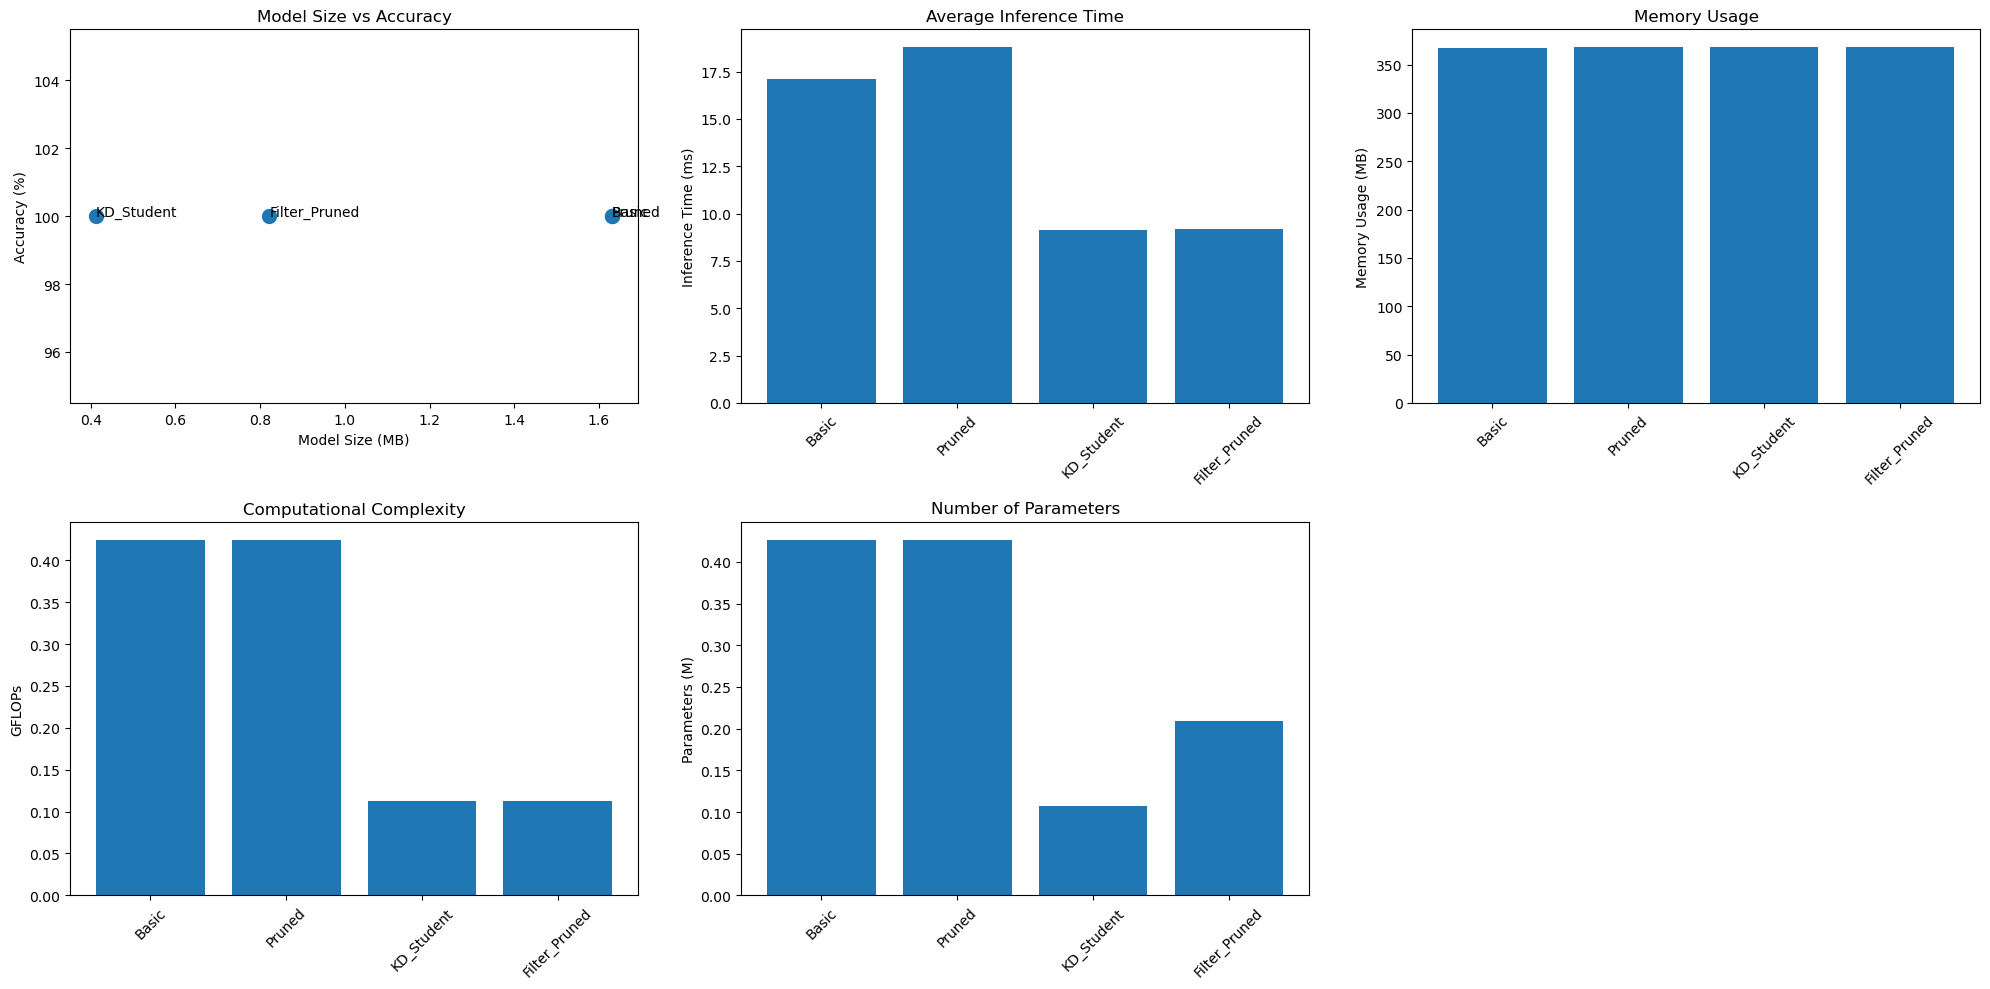

,Model,Parameters,Model_Size_MB,GFLOPs,Avg_Inference_Time_ms,Inference_Time_Std_ms,Memory_Usage_MB,Accuracy_%
0,Basic,426767,1.631178,0.424740,17.117977,2.465008,367.586523,100.0
1,Pruned,426767,1.631178,0.424740,18.791380,1.966877,367.745195,100.0
2,KD_Student,107279,0.412489,0.112589,9.109340,1.400417,368.087227,100.0
3,Filter_Pruned,208655,0.821180,0.112691,9.166186,2.224450,368.126289,100.0


In [9]:
main()